In [1]:
import os
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import random
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate
from keras.optimizers import Adam
from keras import mixed_precision
from keras import backend as K
from keras.metrics import binary_crossentropy

In [2]:
keras.backend.clear_session()

In [3]:
is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

#mixed_precision.set_global_policy('mixed_float16')
#os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"
#os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

True


In [4]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\test_data"

In [36]:
batch_size = 6

In [37]:
def train_gen(suj_path,mask_path):
    
    datagen = ImageDataGenerator(rescale=1/255)
    seed = 777
    
    image_train_generator = datagen.flow_from_directory(suj_path,class_mode=None,color_mode="grayscale",target_size=(256,256),batch_size=batch_size,seed=seed)
    mask_train_generator = datagen.flow_from_directory(mask_path,class_mode=None,color_mode="grayscale",target_size=(256,256),batch_size=batch_size,seed=seed)
    
    train_generator = zip(image_train_generator, mask_train_generator)

    for img,mask in train_generator:
        yield(img,mask)

In [38]:
train_gen_ds = train_gen(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))

val_gen_ds = train_gen(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))


In [9]:
x,y = train_gen_ds.__next__()

Found 4741 images belonging to 1 classes.
Found 4741 images belonging to 1 classes.


In [10]:
print(x.shape)
print(y.shape)
print(x.max(),x.min())
print(y.max(),y.min())

(7, 256, 256, 1)
(7, 256, 256, 1)
1.0 0.0
1.0 0.0


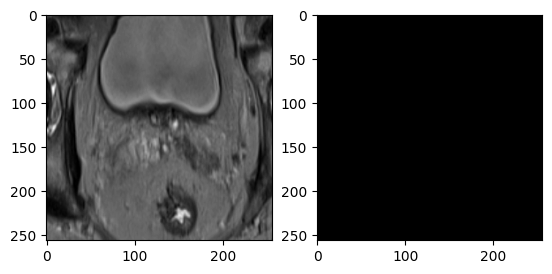

In [26]:
x,y = train_gen_ds.__next__()
for i in range(0,batch_size-1):
    image = x[i,:,:,0]
    mask = y[i,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(mask,cmap="gray")
    plt.show

In [39]:
n_train_img = len(os.listdir(os.path.join(fp1,"sujetos","img")))
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos","img")))
print(n_train_img,n_val_img)
spe = n_train_img//batch_size 
vspe = n_val_img//batch_size

4741 2391


---


In [28]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [29]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation, dtype="float32")(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model
my_unet = build_unet(input_shape=(256,256,1), n_classes= 1)
  #print(my_unet.summary())

In [30]:
def DiceBCE(targets, inputs, smooth=1e-2):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)

def DiceBCELoss(targets, inputs):    
    
    BCE =  binary_crossentropy(targets, inputs)
    
    return BCE + 1 - DiceBCE(targets, inputs, smooth=1e-2)

In [70]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [71]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='modelsh5/unet_model.{epoch:02d}-{val_loss:.2f}-{val_DiceBCE}.h5',save_best_only=True),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=True)
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [72]:
#optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate = 1e-3))
optimizer = Adam(learning_rate = 1e-2)

In [ ]:
my_unet = keras.models.load_model("1_0_926DCE_256.hdf5")

In [73]:
my_unet.compile(optimizer = optimizer, loss = DiceBCELoss, metrics = [DiceBCE])

In [77]:
history2 = my_unet.fit(train_gen_ds,
                    verbose=1, 
                    steps_per_epoch=spe,
                    epochs=50,
                    validation_data=val_gen_ds, 
                    validation_steps=vspe,
                    callbacks=my_callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50
 58/790 [=>............................] - ETA: 6:53 - loss: 0.0858 - DiceBCE: 0.9311

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/U-Net/conv2d_18/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Pier\AppData\Local\Temp\ipykernel_11272\1956259613.py", line 1, in <module>
      history2 = my_unet.fit(train_gen_ds,
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/U-Net/conv2d_18/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[6,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/U-Net/conv2d_18/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_187528]

In [41]:
history2.history['val_DiceBCE']

[0.11372453719377518,
 0.5338578224182129,
 0.610298216342926,
 0.6198311448097229,
 0.7562961578369141,
 0.7193201780319214,
 0.7044329047203064,
 0.7902165055274963,
 0.7737442851066589,
 0.784243106842041,
 0.7519146800041199,
 0.7321506142616272,
 0.7258338332176208,
 0.8432258367538452,
 0.7425855994224548,
 0.8246273398399353,
 0.8125860095024109,
 0.07227186858654022,
 0.8563058376312256,
 0.5330624580383301,
 0.85707688331604,
 0.8649343848228455,
 0.8482827544212341,
 0.8937212228775024,
 0.8809022307395935,
 0.8733020424842834,
 0.871152400970459,
 0.8858485221862793,
 0.9038203954696655,
 0.8449988961219788,
 0.9020527005195618,
 0.8860621452331543,
 0.899323046207428,
 0.8899295330047607]

In [69]:
my_unet.save("1_0_926DCE_256.hdf5")

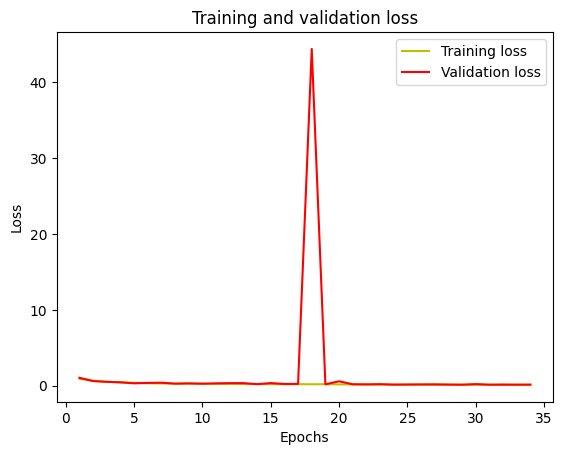

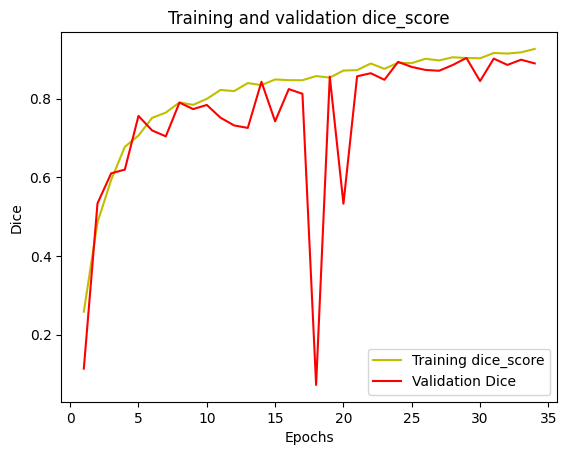

In [42]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['DiceBCE']
val_acc = history2.history['val_DiceBCE']

plt.plot(epochs, acc, 'y', label='Training dice_score')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation dice_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

1/1 [==============================] - 0s 19ms/step
Mean IoU = 1.0


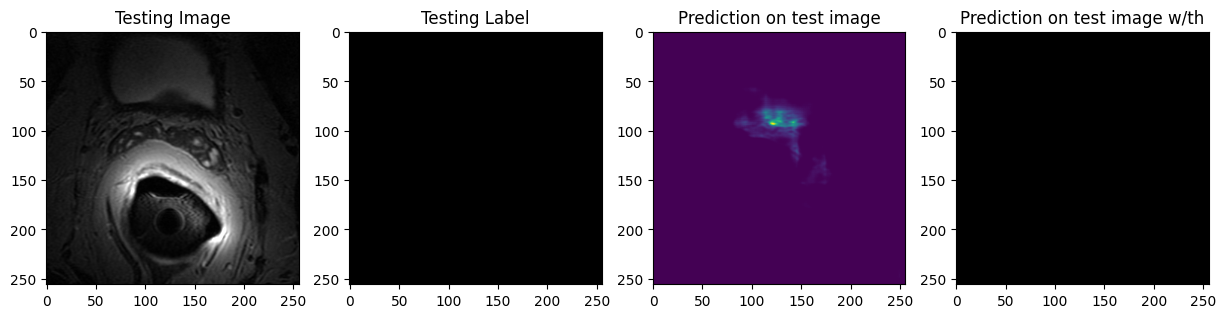

In [68]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (my_unet.predict(test_img_input))
predicted_img_th = prediction[0,:,:,0]>0.5

IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_img_th)
print("Mean IoU =", IOU_keras.result().numpy())

plt.figure(figsize=(15, 10))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,0])
plt.subplot(244)
plt.title('Prediction on test image w/th')
plt.imshow(predicted_img_th, cmap='gray')
plt.show()